In [1]:
!pip install numpy torch torchvision matplotlib kagglehub

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 54.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 3.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 94.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 100.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 4.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import kagglehub
from modules.UNet import UNet
import os

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = kagglehub.dataset_download("humansintheloop/teeth-segmentation-on-dental-x-ray-images")

print("Path to dataset files:", path)

100%|██████████| 4.14G/4.14G [02:19<00:00, 31.8MB/s]

Extracting files...


Path to dataset files: /home/elicer/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1


In [4]:
# 사전 정의된 픽셀 값 매핑 (원본 픽셀 값 -> 0~31 사이의 라벨 값으로 변환)
EXPECTED_MAPPING = {
    0: 0,   15: 1,   29: 2,   38: 3,   53: 4,   67: 5,   75: 6,   76: 7,
    79: 8,  90: 9,   91: 10, 104: 11, 105: 12, 113: 13, 128: 14, 142: 15,
  150: 16, 151: 17,  164: 18, 166: 19, 179: 20, 188: 21, 192: 22, 202: 23,
  205: 24, 223: 25,  226: 26, 251: 27, 255: 28, 240: 29, 250: 30, 245: 31
}

def map_mask_fixed(mask):
    """
    사전 정의된 EXPECTED_MAPPING을 사용하여 mask의 픽셀 값을 0~31로 매핑하는 함수.
    예상치 못한 값이 존재하면 ValueError를 발생시킴.
    Args:
        mask (PIL.Image or np.ndarray): 입력 마스크 이미지
    Returns:
        torch.Tensor: 변환된 마스크 텐서 (dtype=torch.long)
    """
    # 입력이 numpy 배열이 아닐 경우 변환시켜 반환
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)
    
    # 매핑된 마스크를 저장할 배열 생성
    mapped = np.zeros_like(mask, dtype=np.int64)

    # EXPECTED_MAPPING을 사용하여 값 변환
    for orig_val, target in EXPECTED_MAPPING.items():
        mapped[mask == orig_val] = target
    
    # 변환된 마스크 내 유효하지 않은 값(EXPECTED_MAPPING에 정의되지 않은 값)이 있는지 확인
    unique_vals = np.unique(mask)
    for val in unique_vals:
        if val not in EXPECTED_MAPPING:
            raise ValueError(f"Mask contains unexpected value {val}. Expected keys: {list(EXPECTED_MAPPING.keys())}")
    return torch.as_tensor(mapped, dtype=torch.long)


class XRayDataset(Dataset):
    """
    X-ray 이미지 및 해당 마스크를 로드하는 PyTorch Dataset 클래스.
    Args:
        images_dir : 이미지 파일이 저장된 디렉토리 경로
        masks_dir : 마스크 파일이 저장된 디렉토리 경로
        transform : 이미지에 적용할 변환 함수
        mask_transform : 마스크에 적용할 변환 함수
    """
    def __init__(self, images_dir, masks_dir, transform, mask_transform):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_ids = os.listdir(images_dir)

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):

        image_id = self.image_ids[idx]
        image_path = os.path.join(self.images_dir, image_id)

        # 마스크 확장자는 png이므로 변경
        mask_id = os.path.splitext(image_id)[0] + ".png"
        mask_path = os.path.join(self.masks_dir, mask_id)
        
        # 모델의 입력 채널이 3이므로 image는 RGB로 로드, 마스크는 흑백으로 로드.
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        

        image = self.transform(image)
        mask = self.mask_transform(mask)
        
        return image, mask

In [ ]:
# 훈련 데이터 리사이징/증강
train_image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3439, 0.3439, 0.3439], std=[0.2127, 0.2127, 0.2127])
])
# 검증/테스트 데이터는 리사이징 및 정규화만 적용
val_test_image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3439, 0.3439, 0.3439], std=[0.2127, 0.2127, 0.2127])
])
# 마스크 데이터 변환
mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST), # 라벨 손실 방지를 위해 최근접 이웃 보간법 사용
    transforms.Lambda(lambda pic: map_mask_fixed(pic)) # 람다 함수로 마스크의 픽셀 값에 클래스 매핑
])

In [ ]:
# 데이터셋 경로 (실제 경로로 수정)
"""
images_dir = '/home/elicer/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1/Teeth Segmentation PNG/d2/img'
masks_dir = '/home/elicer/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1/Teeth Segmentation PNG/d2/masks_machine'
"""
images_dir = '/home/elicer/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1/Teeth Segmentation PNG/d2/img'
masks_dir = '/home/elicer/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1/Teeth Segmentation PNG/d2/masks_machine'
full_dataset = XRayDataset(images_dir, masks_dir, transform=train_image_transforms, mask_transform=mask_transforms)


In [7]:
# 데이터 분할: 70% 학습, 15% 검증, 15% 테스트
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [8]:
# 검증, 테스트 데이터셋은 증강 없이 적용
val_dataset.dataset.transform = val_test_image_transforms
test_dataset.dataset.transform = val_test_image_transforms

In [9]:
# DataLoader 생성
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
# 일정 에포크 이상 검증 성능이 개선되지 않으면 학습을 중지하는 EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience, verbose, delta):
        """
        Args:
            patience : 검증 성능이 개선되지 않는 최대 에포크 수.
            verbose : True이면 트리거 실행까지 남은 에포크 수 표시.
            delta : 최소 loss 감소량
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [ ]:
# 모델, optimizer, loss, device 설정
num_classes = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=num_classes, dropout_p=0.3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6) 
criterion = nn.CrossEntropyLoss()

In [ ]:
# ReduceLRONPlateau 스케줄러, EarlyStopping 객체 생성
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.001)

/home/elicer/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# 현재 사용중인 디바이스 출력
if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"현재 사용 중인 GPU: {device_name}")
else:
    print("CUDA 사용 불가, CPU 사용 중!")

현재 사용 중인 GPU: NVIDIA A100 80GB PCIe


In [14]:
# 학습 및 검증 루프
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break


Epoch 1/100, Train Loss: 1.5638, Val Loss: 0.9292
Epoch 2/100, Train Loss: 0.9434, Val Loss: 0.7727
Epoch 3/100, Train Loss: 0.7595, Val Loss: 0.6931
Epoch 4/100, Train Loss: 0.7213, Val Loss: 0.7035
EarlyStopping counter: 1 out of 3
Epoch 5/100, Train Loss: 0.7016, Val Loss: 0.6607
Epoch 6/100, Train Loss: 0.6946, Val Loss: 0.6521
Epoch 7/100, Train Loss: 0.6813, Val Loss: 0.6412
Epoch 8/100, Train Loss: 0.6682, Val Loss: 0.6302
Epoch 9/100, Train Loss: 0.6583, Val Loss: 0.6255
Epoch 10/100, Train Loss: 0.6480, Val Loss: 0.6144
Epoch 11/100, Train Loss: 0.6338, Val Loss: 0.6077
Epoch 12/100, Train Loss: 0.6235, Val Loss: 0.5865
Epoch 13/100, Train Loss: 0.6128, Val Loss: 0.5734
Epoch 14/100, Train Loss: 0.5934, Val Loss: 0.5631
Epoch 15/100, Train Loss: 0.5766, Val Loss: 0.5315
Epoch 16/100, Train Loss: 0.5670, Val Loss: 0.5270
Epoch 17/100, Train Loss: 0.5538, Val Loss: 0.5138
Epoch 18/100, Train Loss: 0.5430, Val Loss: 0.5036
Epoch 19/100, Train Loss: 0.5199, Val Loss: 0.4744
Epoch 

In [15]:
# 테스트 과정
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()
avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 0.1363


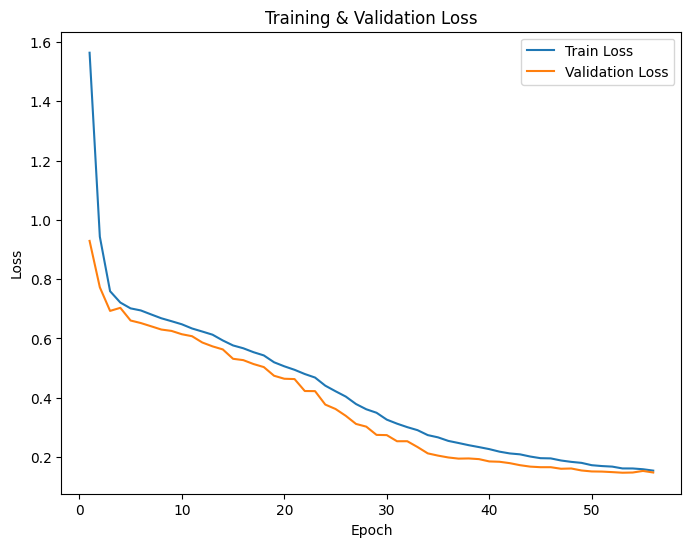

In [16]:
# 학습 및 검증 loss 그래프 그리기
epochs = len(train_losses)
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

Random test sample index: 88


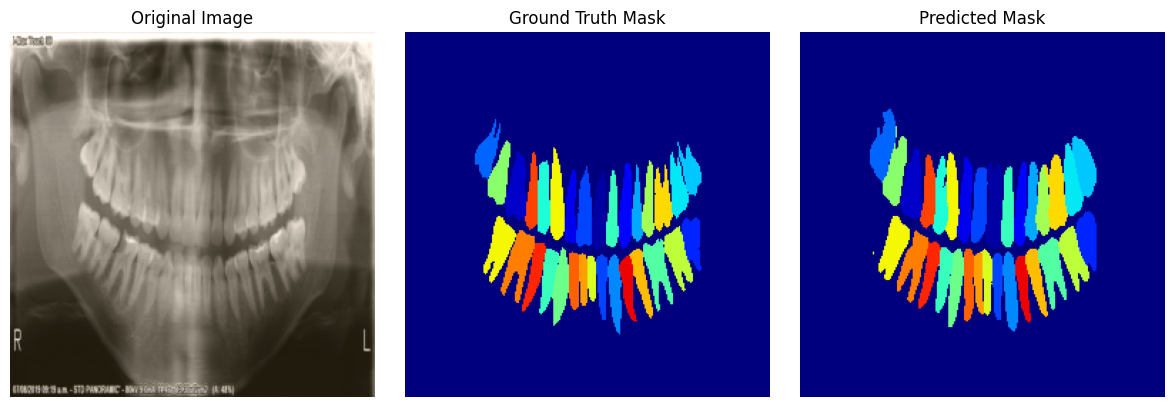

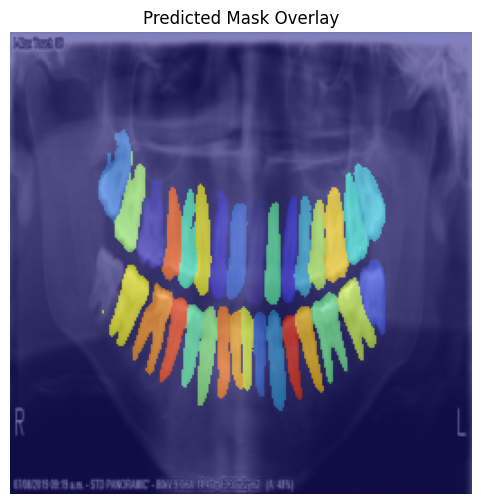

In [ ]:
# 모델이 생성한 마스크 시각화 (테스트 데이터셋에서 랜덤 샘플 선택)
model.eval()
rand_idx = random.randint(0, len(test_dataset)-1)
print(f"Random test sample index: {rand_idx}")
image, true_mask = test_dataset[rand_idx]
image_tensor = image.unsqueeze(0).to(device)
with torch.no_grad():
    output = model(image_tensor)

# 모델 출력에서 가장 높은 값(가장 확률이 높은 클래스) 선택하여 마스크 생성    
# argmax를 사용해 채널 차원을 제거하고 2D 마스크로 변환
pred_mask = torch.argmax(output, dim=1).squeeze(0)

# 텐서를 (H, W, C) 형식의 numpy 배열로 변환
img_np = image.cpu().numpy().transpose(1, 2, 0)
mean = np.array([0.3439, 0.3439, 0.3439])
std = np.array([0.2127, 0.2127, 0.2127])

# 정규화 해제 (원래 픽셀 값으로 복원)
img_np = std * img_np + mean

# 값의 범위를 0~1로 제한하여 시각적으로 이상이 없도록 처리
img_np = np.clip(img_np, 0, 1)

# 실제 마스크 및 예측 마스크를 numpy 배열로 변환
true_mask_np = true_mask.cpu().numpy()
pred_mask_np = pred_mask.cpu().numpy()

# 원본 이미지, 실제 마스크, 예측 마스크 출력
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(true_mask_np, cmap='jet', vmin=0, vmax=num_classes-1)
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask_np, cmap='jet', vmin=0, vmax=num_classes-1)
plt.title("Predicted Mask")
plt.axis("off")
plt.tight_layout()
plt.show()

# 원본 이미지 위에 예측 마스크를 반투명하게 표시하는 오버레이 방식 출력 
plt.figure(figsize=(6, 6))
plt.imshow(img_np)  # 원본 이미지 표시
# 예측 마스크를 jet 컬러맵과 alpha=0.5로 오버레이
plt.imshow(pred_mask_np, cmap='jet', alpha=0.5, vmin=0, vmax=num_classes-1)
plt.title("Predicted Mask Overlay")
plt.axis("off")
plt.show()

In [18]:
# 모델 저장
torch.save(model.state_dict(), "Unet_segmentation_model.pth")

In [19]:
from IPython.display import FileLink

FileLink('Unet_segmentation_model.pth')

/home/elicer/Unet_segmentation_model.pth